**Find the smallest sphere that encloses a set of** $k$ **points** $p_i \in R^n$. **as a second order conic problem:**



\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_i \geq \| p_i - p_0\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& (r_0,p_i - p_0) \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

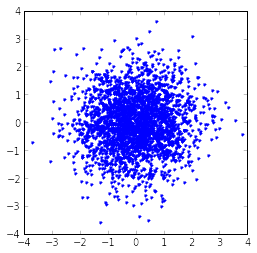

In [1]:
%matplotlib inline
import numpy as np
import plot as mskplt

n = 2
k = 2500

p=  np.random.normal(size=(k,n))

mskplt.plot_points(p)


In [2]:
import sys
from mosek.fusion import *
import time

start = time.time()

M = Model("minimal sphere enclosing a set of points")


Note that we have organized our data by row, i.e. each point is a row vector.

The next step is two define the problem variables:

In [3]:
r0 = M.variable("r_0", Domain.unbounded())
p0 = M.variable("p_0", NDSet(1,n), Domain.unbounded())

Before defining the constraints, we note that we can write


\begin{equation}
r = \left(r_0,\ldots,r_0\right)^T \in \mathbb{R}^k
\end{equation}

and 

\begin{equation}
P = \left(p_0,\ldots,p_k\right)^T \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
(r_0,p_i - p_0) \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
(r,P) \in \Pi Q^{(n+1)}.
\end{equation}

This formulation allows to use a single call to Fusion:


In [4]:
ee = Expr.hstack( Variable.repeat(r0,k),Expr.sub( Variable.repeat(p0,k), DenseMatrix(p) ) )

M.constraint(ee, Domain.inQCone())
print('Primal model building time: ',time.time() - start)

output = open('log','wt')
M.setLogHandler(output)


M.objective(ObjectiveSense.Minimize, r0)

M.solve()

rstar= r0.level()[0]
pstar= p0.level()
 
print("r*= %f" % rstar)
print("p*= ", pstar)
    

('Primal model building time: ', 5.3812291622161865)
r*= 3.861099
('p*= ', [-0.01350432947032254, 0.06297809670328436])


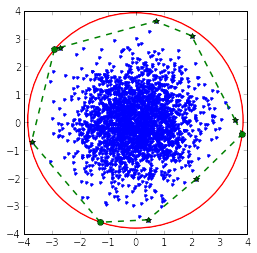

In [5]:
mskplt.plot_points(p,pstar,rstar)

=Dual Formulation=

Let's derive the dual:

\begin{aligned}
    \max & \sum_i b_i^T y_i \\
    & \sum_i y_i = c \\
    & y_i \in \mathcal{Q}^{n+1}
\end{aligned}


where $c=\left(1, 0_n\right)^T$ and $b_i=(0,p_i)$. Introducing 

\begin{equation}
 Y = \left[ y_0, \ldots,y_k  \right], B=\left[ b_1,\ldots,b_k\right]
\end{equation}


\begin{aligned}
    \max & \left< B, Y \right> \\
    & Y \mathbb{1}_k = c \\
    & Y_{:,i} \in \mathcal{Q}^{n+1}
\end{aligned}



Let's take a closer look to the solver output:

In [6]:
Md = Model()

y= Md.variable(NDSet(k,n+1), Domain.inQCone(k,n+1))
Md.constraint( Expr.mul( [1.0 for i in range(k)], y), Domain.equalsTo( [1.] + [0. for i in range(n)]) )
    
Md.objective(ObjectiveSense.Maximize, Expr.dot( DenseMatrix(p.tolist()), y.slice([0,1],[k,n+1])) )
 
outputd = open('logd','wt')
Md.setLogHandler(outputd)

Md.solve()


In [7]:
%%bash
cat log

Computer
  Platform               : Linux/64-X86    
  Cores                  : 2               

Problem
  Name                   : minimal sphere enclosing a set of points
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7500            
  Cones                  : 2500            
  Scalar variables       : 7503            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Optimiz

In [8]:
%%bash
cat logd

Computer
  Platform               : Linux/64-X86    
  Cores                  : 2               

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3               
  Cones                  : 2500            
  Scalar variables       : 7500            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Optimizer  - threads           

The important point is the the flop and the dense dimensions

In [9]:
%%bash
grep flop log*

log:Factor     - dense dim.             : 5                 flops                  : 4.85e+05        
logd:Factor     - dense dim.             : 0                 flops                  : 6.50e+04        


In [21]:
%%bash
grep flop log* | cut -d':' -f 4 



 4.85e+05        
 6.50e+04        


In [11]:
4.85e+05/6.50e+04

7.461538461538462

In [13]:
0.15/0.08

1.875